# Artificial Persuasive Intelligence

In [1]:
pip install chromadb

  Using cached chromadb-0.6.3-py3-none-any.whl.metadata (6.8 kB)
  Using cached build-1.2.2.post1-py3-none-any.whl.metadata (6.5 kB)
  Using cached chroma_hnswlib-0.7.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (252 bytes)
  Using cached posthog-3.23.0-py2.py3-none-any.whl.metadata (3.0 kB)
  Using cached onnxruntime-1.21.0-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (4.5 kB)
  Using cached opentelemetry_exporter_otlp_proto_grpc-1.31.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached opentelemetry_instrumentation_fastapi-0.52b1-py3-none-any.whl.metadata (2.2 kB)
  Using cached pypika-0.48.9-py2.py3-none-any.whl
  Using cached kubernetes-32.0.1-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached mmh3-5.1.0-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (16 kB)
  Using cached pyproject_hooks-1.2.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached requests_oauthlib-2.0.0-py2.p

In [4]:
pip install anthropic

  Using cached anthropic-0.49.0-py3-none-any.whl.metadata (24 kB)
  Using cached jiter-0.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.2 kB)
Using cached anthropic-0.49.0-py3-none-any.whl (243 kB)
Using cached jiter-0.9.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (351 kB)
Note: you may need to restart the kernel to use updated packages.


## Libraries

In [10]:
from datasets import load_dataset, Value, Sequence, Features
import chromadb
import pandas as pd
import re
import numpy as np 
import chuck_gpt
import concurrent
import boto3
from datetime import datetime as dt
import inspect

from importlib import reload
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, DotProduct
from scipy.stats import ecdf, norm
import random
import requests
import json
import chuck_gpt

In [11]:
def extract_json(answer):

    cleaned_answer = re.sub('`', '', answer)
    cleaned_answer = re.sub('json', '', cleaned_answer)
    cleaned_answer = re.sub('null', 'np.nan', cleaned_answer)
    cleaned_answer = re.sub("\n", ' ', cleaned_answer)
    cleaned_answer = re.sub("”", "\"", cleaned_answer)
    cleaned_answer = re.sub("\$", '', cleaned_answer)
    
    return eval(cleaned_answer)
    
def remove_name(name, text):
    lines = [x for x in text.split("\n") if len(x) > 0]
    lines[0] = re.sub(name + ': ', '', lines[0])
    return lines[0] + "\n" + "\n".join(['     '  + x for x in lines[1:]])

def subsample(df, n):
    if df.shape[0] > n:
        sdf = df.sample(n)
    else:
        sdf = df
    return "\n".join(["Review: {}\n- {}\nRating: {}\n".format(t, v, r) for t, v, r in zip(sdf['title'], 
                                                                                          sdf['text'],
                                                                                          sdf['rating'])])

## Load Data from Huggingface

In [12]:
metadata = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_All_Beauty", split="full")

Reusing dataset amazon_review2023 (/home/sagemaker-user/.cache/huggingface/datasets/McAuley-Lab___amazon_review2023/raw_meta_All_Beauty/0.0.0/16b76e0823d73bb8cff1e9c5e3e37dbc46ae3daee380417ae141f5e67d3ea8e8)


In [13]:
features_example = Features({'rating': Value(dtype='float'),
 'title': Value(dtype='string'),
 'text': Value(dtype='string'),
                        
 'images': Sequence(feature=Value(dtype='string'), id=None),
 'asin':  Value(dtype='string'),
 'parent_asin':  Value(dtype='string'),
 'user_id': Value(dtype='string'),
 'timestamp': Value(dtype='int64'),
 'helpful_vote': Value(dtype='int32'),
 'verified_purchase': Value(dtype='bool')})

### Just use products with descriptions

In [14]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", features=features_example)
reviews_df = pd.DataFrame(dataset['full'][slice(0, 300000)])
products_df = pd.DataFrame(metadata[:300000])
df = reviews_df.merge(products_df, on='parent_asin')
reviews_df.to_csv('reviews.csv')

Using custom data configuration raw_review_All_Beauty-8e916b816ac3c3e0
Reusing dataset amazon_review2023 (/home/sagemaker-user/.cache/huggingface/datasets/McAuley-Lab___amazon_review2023/raw_review_All_Beauty-8e916b816ac3c3e0/0.0.0/16b76e0823d73bb8cff1e9c5e3e37dbc46ae3daee380417ae141f5e67d3ea8e8)


  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
#client = chromadb.PersistentClient(path="/home/sagemaker-user/user-default-efs/projects/persuasio/chroma_dbs")
client = chromadb.PersistentClient(path="/home/sagemaker-user/user-default-efs/projects/persuasio/chroma_small")


In [16]:
with_description_df = df[[True  if len(x) > 0 else False for x in df['description']]]
descriptions = with_description_df[['asin', 'parent_asin', 'description', 'average_rating', 
                                    'title_y', 'price', 'rating_number', 'images_y']].drop_duplicates(subset='parent_asin', inplace=False)
descriptions.shape

(13701, 8)

### Vector DB

In [18]:
description_db = client.create_collection(name="amazon_beauty_descriptions")
description_db.count()
#description_db = client.delete_collection(name="amazon_beauty_descriptions")


0

In [19]:
start = 0
end = 2000
description_db.add(
    documents=[x[0] for x in descriptions['description'].iloc[start:end]],
    ids=[str(x) for x in descriptions['parent_asin'].iloc[start:end]], # parent_asin makes it easier for now
    metadatas=[{'average_rating': r,
                'price': c,
                'rating_number': c,
#                'hi_res': "\n".join(i['hi_res']),
                'large': "\n".join(i['large']),
                'thumb': "\n".join(i['thumb']),
                'title': t} for r, p, c, i, t in zip(descriptions['average_rating'].iloc[start:end],
                                                         descriptions['price'].iloc[start:end],
                                                         descriptions['rating_number'].iloc[start:end],
                                                         descriptions['images_y'].iloc[start:end],
                                                         descriptions['title_y'].iloc[start:end])] # could pull this later
) 

## Agents

In [15]:
def summarize(reviews):
    background = 'You are an editor'
    prompt = ['You will be given a list of product reviews',
              'Summarize all the reviews. Be sure to retain all of the important points.',
              'Only eliminate redundant points.',
              'Do not introduce or label your summary.',
              'Do not include a header',
              'Do you give any other text.',
              "\n### REVIEWS ###\n{}\n\n".format(reviews)]
    return chuck_gpt.call_nova(" ".join(background), [{'text': " ".join(prompt)}], nova_config)
#    return chuck_gpt.call(" ".join(background), " ".join(prompt))

In [25]:
nova_config = {'max_tokens': 256,
               'topP': .8,
               'topK': 100,
               'temp': .9}

In [17]:
def salesman(transcript_of_conversation: 'transcript', search_results: 'rag') -> 'string':

    background = ['You are a sales person at a beauty store and your name is \'Megan\'.',
                  'You are speaking with a customer.']
    prompt = ['Your goal is to help the customer shop.'
              'You are in the middle of a conversation',
              'You will be given a transcript of the conversation so far',
              'You will also be given the descriptions and reviews of some relevant products in our inventory.',
              'You get 10% comission. You want to maximize your comission without seeming too pushy.',
              'Do not label, introduce your response or add a heading.',
              'Respond in 5 sentances or less. Your comment can be very short if you\'re just trying to build a rapport.',
              "\n### SEARCH RESULTS ###\n{}\n\n".format(search_results),
              "\n### TRANSCRIPT OF CONVERSATION SO FAR ###\n{}\n\n".format(transcript_of_conversation)]
    return chuck_gpt.call_nova(" ".join(background), [{'text': " ".join(prompt)}], nova_config)
#    return chuck_gpt.call(" ".join(background), " ".join(prompt))


In [18]:

def prospect(transcript):
    background = ["You are a shopper at beauty store. Your name is 'Dasha'."]
    prompt = ['You are speaking with a sales person named \'Megan\'.',
              'You will be given a transcript of your conversation so far.',
              'Do not label, introduce your response or add a heading.',
              "\n### TRANSCRIPT OF DIALOGUE SO FAR ###\n{}\n\n".format(transcript)]
    reply = chuck_gpt.call_nova(" ".join(background), [{'text': " ".join(prompt)}], nova_config)
#    reply = chuck_gpt.call(" ".join(background), " ".join(prompt))
    return reply

In [20]:
example = """John: Hello, How can I help you?
Lisa: Hi. I'm remodeling my bathroom and I was wondering if you can help me pick out some good lighting? It's for the vanity.
"""
example2 = """Bart: Hello, How can I help you?
Jose: Hello. I need a lawn mower.
Bart: OK. I can help you with that. Are you looking for a riding lawnmower or push?
Jose: Push
Bart: Electric or Gas
Jose: Gas. Those electric ones aren't very powerful and I think they breakdown.
Bart: Well, actually they've gotten better but I can show you the as ones first and then if you'd like to take a quick glance at the electric ones, I can show you thoses as well
"""
answer = "```[\"Bathroom lighting that is arranged above the mirror in a bathroom is sometimes described as 'Vanity Bathroom Lighting'.\"]```"
answer2 = "```[\"A gas powered push lawn mower tends to have power and durability.\", \"Electric powered push lawnmowers are more enironmentally friendly and can save money on gas. Sometimes they have less power than gas mowers, but recently, they have been getting better.\"]```"

def search(transcript):
    background = 'You are a solution designer. Your job is to take a conversation and create relevant product descriptions.'
    prompt = ['You will be given a transcript of a conversation between a sales associate and a customer.',
              'Come up with descriptions of products discussed in the conversation.',
              'There may be more than one product being mentioned.',
              'ONLY provide the descriptions in a list format surrounded by tickmarks.',
              'DO NOT include introductions, context, rationales or any other text',
              "\n### EXAMPLE TRANSCRIPT 1 ###\n{}\n\n".format(example),
              "### EXAMPLE ANSWER 1 ###\n{}\n\n".format(answer),
              "### EXAMPLE TRANSCRIPT 2 ###\n{}\n\n".format(example2),
              "### EXAMPLE ANSWER 2 ###\n{}\n\n".format(answer2),
              "### REAL TRANSCRIPT ###\n{}\n\n".format(transcript)]

    return chuck_gpt.call_nova(" ".join(background), [{'text': " ".join(prompt)}], nova_config)
#    return chuck_gpt.call(" ".join(background), " ".join(prompt))

    

In [27]:
example = """John: Hello, How can I help you?
Lisa: Hi. I'm remodeling my bathroom and I was wondering if you can help me pick out some good lighting? It's for the vanity.
"""
example2 = """Bart: Hello, How can I help you?
Jose: Hello. I need a some facial cleanser.
Bart: OK. I can help you with that. Are you looking for a riding lawnmower or push?
Jose: Push
Bart: Electric or Gas
Jose: Gas. Those electric ones aren't very powerful and I think they breakdown.
Bart: Well, actually they've gotten better but I can show you the as ones first and then if you'd like to take a quick glance at the electric ones, I can show you thoses as well
"""
answer = "```[\"Bathroom lighting that is arranged above the mirror in a bathroom is sometimes described as 'Vanity Bathroom Lighting'.\"]```"
answer2 = "```[\"A gas powered push lawn mower tends to have power and durability.\", \"Electric powered push lawnmowers are more enironmentally friendly and can save money on gas. Sometimes they have less power than gas mowers, but recently, they have been getting better.\"]```"

def search_w_check(transcript):
    background = 'You are a solution designer. Your job is to take a conversation and create relevant product descriptions.'
    prompt = ['You will be given a transcript of a conversation between a sales associate and a customer.',
              'Come up with descriptions of products discussed in the conversation.',
              'There may be more than one product being mentioned.',
              'ONLY provide the descriptions in a list format surrounded by tickmarks.',
              'DO NOT include introductions, context, rationales or any other text',
              "\n### EXAMPLE TRANSCRIPT 1 ###\n{}\n\n".format(example),
              "### EXAMPLE ANSWER 1 ###\n{}\n\n".format(answer),
              "### EXAMPLE TRANSCRIPT 2 ###\n{}\n\n".format(example2),
              "### EXAMPLE ANSWER 2 ###\n{}\n\n".format(answer2),
              "### REAL TRANSCRIPT ###\n{}\n\n".format(transcript)]

    return chuck_gpt.call_nova(" ".join(background), [{'text': " ".join(prompt)}], nova_config)
#    return chuck_gpt.call(" ".join(background), " ".join(prompt))

    

In [23]:
from importlib import reload
reload(chuck_gpt)

<module 'chuck_gpt' from '/mnt/custom-file-systems/efs/fs-0efe0723c8fe23def_fsap-009815092600551f0/projects/persuasio/chuck_gpt.py'>

In [21]:
greeting = 'Megan: Hi, my name is Megan. Is there something I can I help you with?'
reply = input(greeting)

Megan: Hi, my name is Megan. Is there something I can I help you with? I'm looking for something to make me look tan.


In [26]:
conversation = [greeting, 'Dasha: ' + reply]
search_terms = search("\n".join(conversation))
search_terms = re.sub('`', '', (search_terms))
search_terms

'["Products that enhance or create a tan appearance, such as self-tanning lotions, sprays, and mousses.", "Tanning beds that provide an artificial source of UV radiation to simulate a sun-induced tan."]'

In [132]:
results = description_db.query(
    query_texts=search_terms,
    n_results=3
)

### Remove duplicates

In [133]:
search_df = pd.DataFrame({'title': [title['title'] for meta in results['metadatas'] for title in meta],
                          'description': [d for doc in results['documents'] for d in doc],
                          'id': [idx for ids in results['ids'] for idx in ids]})
search_df = search_df.drop_duplicates(subset='id', inplace=False)

In [70]:
from PIL import Image
import urllib.request
from io import BytesIO 
for i in range(len(results['metadatas'])):
    for j in range(len(results['metadatas'][i])):
        images = results['metadatas'][i][j]['large'].split("\n")
        with urllib.request.urlopen(images[0]) as url:
            img = Image.open(BytesIO(url.read()))
        display(img)

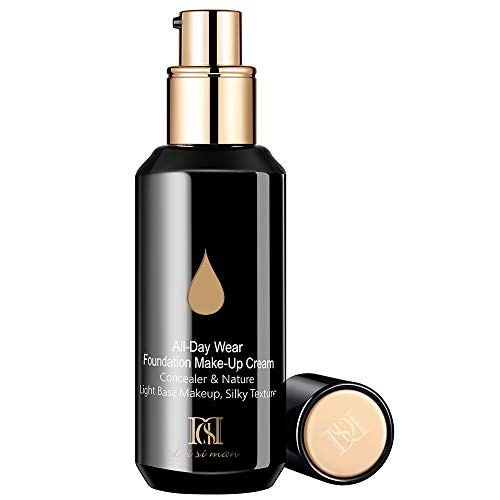

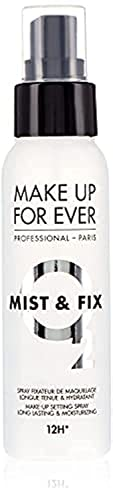

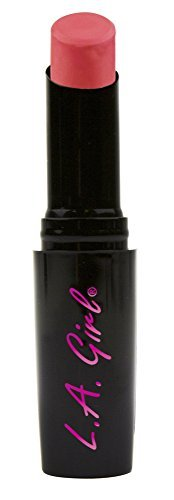

## MCTS

In [51]:
eval_config = {'max_tokens': 512,
               'topP': .5,
               'topK': 50,
               'temp': .01}


def evaluator(transcript):
    list_of_items = """
    {'pink skirt': 'low',
     'aviator sunglasses': 'low',
     'women\'s green socks': 'medium',
     'vinyl jacket': 'very low'}
"""
    background = ["You are a sales trainer.",
                  "Your job is to estimate the probability that a conversation will lead to a sale."]
    prompt = ["You will be given a transcript of a conversation.",
              "State the likliehood that conversation will lead to the sale of each item as 'Very High', 'High', 'Medium', 'Low' or 'Very Low'",
              "Always use lower case and put your answer in json format like this:{}\n".format(list_of_items),
              "Do not include any other text, introduction, rationale or explanation.",
              "### TRANSCRIPT ###\n{}\n\n".format(transcript)]
   
    return chuck_gpt.call_nova(" ".join(background), [{'text': " ".join(prompt)}], eval_config) 

In [50]:
from sys import exit
import boto3
import json
import re
from botocore.exceptions import ClientError

def embedding(input_text):

    client = boto3.client(service_name="bedrock-runtime", region_name='us-east-2',
                          aws_access_key_id=os.environ['AWS_ACCESS_KEY'],
                          aws_secret_access_key=os.environ['AWS_ACCESS_SECRET'])
    
    model_id = "amazon.titan-embed-text-v2:0"

    accept = "application/json"
    content_type = "application/json"
    body = json.dumps({
        "inputText": input_text,
        'dimensions': 512#,
#        "embeddingTypes": ["binary"]
    })
    response = client.invoke_model(
        body=body, modelId=model_id, accept=accept, contentType=content_type
    )

    response_body = json.loads(response.get('body').read())

    return response_body['embedding']
    

In [49]:
def add_child(n):
    n.add_child()


class node:
    def __init__(self, name, other_name, statement, level,
                 roles, parent=None):
        self.name = name
        self.other_name = other_name
        self.statement = statement
        self.children = []
        self.parent = parent
        self.mu = 0
        self.level = level
        self.sigma = 0
        self.roles = roles
        self.embedding = None
        transcript = "\n".join(conversation) + self.read()

        self.evaluation = extract_json(evaluator(transcript))

    def get_embedding(self):
        
        if not self.embedding:
            self.embedding = chuck_gpt.embedding("\n".join(conversation) + "\n" + l.read())
        return self.embedding
        
    def add_child(self, rag=None, statement=None):
        if statement:
            self.children.append(node(self.other_name, self.name, turn, self.level+1, self.roles, self))
        else:
            transcript = "\n".join(conversation) + self.read()
            f = self.roles[self.other_name]
            if len(inspect.getfullargspec(f).args) == 2:
                self.response = f(transcript, rag)
            else:
                self.response = f(transcript)
            response = remove_name(self.other_name, self.response)
            self.children.append(node(self.other_name, self.name, response, self.level+1, self.roles, self))

    def score_lineage(self):

        if self.parent:
            chain = self.parent.score_lineage()
            chain[self.name].append(self.score[self.name])
            chain[self.other_name].append(self.score[self.other_name])
        else:
            chain = {self.name: [self.score[self.name]],
                     self.other_name: [self.score[self.other_name]]}

        return chain.copy()
    
    def print_tree(self):
        if len(self.children) > 0:
            for c in self.children:
                c.print_tree()
        print('-' * self.level + "\n".join(self.statement.split("\n")[:2]))
        
    def read(self):

        previous_chain = ""
        if self.parent:
            previous_chain = self.parent.read()

        return previous_chain + self.name + ': ' + self.statement + "\n"

    def stat(self):
        value = {'very high': .9, 'high': .7, 'medium': .5, 'low': .3, 'very low': .05}
        for child in self.children:
            child.score = 0
            for item in child.evaluation.keys():
                child.score += value[child.evaluation[item]]

        self.mu = np.mean([c.score for c in self.children])
        self.sigma = np.std([c.score for c in self.children])
        return self.mu, self.sigma


    def flatten(self):

        flat = [self]
        for c in self.children:
            flat += c.flatten()
        return flat


In [152]:
def create_batches(gpr, rollout_embeddings, n_batches):
    batch_mu = []
    batch_sigma = []
    batches = []
    batch_idx = []
    n_to_choose_from = len(rollout_embeddings)
    for z in range(n_batches):
        batch = [random.randint(0, n_to_choose_from-1) for x in range(4)]
        batch_idx.append(batch)
        m, s = gpr.predict([rollout_embeddings[i] for i in batch], return_cov=True)
        batch_mu.append(','.join([str(x) for x in m]))
        sigma = []
        for x in s:
            sigma.append(','.join([str(y) for y in x]))
        batch_sigma.append(';'.join(sigma))
    return batch_idx, batch_mu, batch_sigma

def get_best_batch(batch_mu, batch_sigma):
    url = 'https://boaz.onrender.com/qei?y_best=.02&n=4'
    data = {'k': ';'.join(batch_mu),
            'sigma': '|'.join(batch_sigma)}
    response = requests.post(url, json.dumps(data))
    boaz = eval(response.content.decode('utf-8'))
    
    fboaz = [float(x) for x in boaz['scores'].split(',')]
    best = -1
    for i, mx in enumerate(fboaz):
        if mx > best:
            best = float(mx)
            best_idx = i
    return best_idx

In [143]:
from importlib import reload
reload(chuck_gpt)

<module 'chuck_gpt' from '/mnt/custom-file-systems/efs/fs-0efe0723c8fe23def_fsap-009815092600551f0/projects/persuasio/chuck_gpt.py'>

## TO DO
include images

### Format search results and summary of relevant products

In [140]:
product_info = ''
for y in range(len(results['ids'])):
    for x in range(len(results['ids'][y])):
        review_summary = summarize(subsample(reviews_df[reviews_df['parent_asin'] == results['ids'][y][x]], 10))
        product_info += "{}. {}\n- {}\n\nSummary of a Sample of Reviews\n{}\n\n".format(x+1, results['metadatas'][y][x]['title'], results['documents'][y][x], review_summary)   
        product_info += "Overall Average: {}\nNumber of Ratings: {}\n\n".format(results['metadatas'][y][x]['average_rating'], results['metadatas'][y][x]['rating_number'])


us.anthropic.claude-3-haiku-20240307-v1:0
You will be given a list of product reviews Summarize all the reviews. Be sure to retain all of the important points. Only eliminate redundant points. Do not introduce or label your summary. Do not include a header Do you give any other text. 
### REVIEWS ###
Review: Heavy!!! All colors are pale
- Pale and very heavy on your face... Not a fan!
Rating: 1.0

Review: Way too thick
- This does not look at all natural - super thick coverage. Not what I expected.
Rating: 2.0

Review: Great product
- I love this foundation! Other foundations I have used usually don't last all day and you have to reapply so you won't look like your melting, but with this foundation it really does last all day and it's full coverage is amazing! This is definitely my go to foundation now and I will definitely be buying more in the future.
Rating: 5.0



us.anthropic.claude-3-haiku-20240307-v1:0
You will be given a list of product reviews Summarize all the reviews. Be sur

In [141]:
print(product_info)

1. Liquid Foundation Cream Waterproof Sweatproof Sweat-Resistant Long-Lasting (30# Natural color)
- Enhance facial skin luster, make skin soft and natural, oil-controlling makeup, moisturizing and moisturizing; powdery texture is fine and smooth, blends with the skin, natural and clear, velvety matte makeup, natural without fake face *Moisturizing and long-lasting makeup is not dull *Anti-sweat and non-sticky *Soft mist light makeup *Delicate paste *Rinse with water, it is not easy to take off make-up when meeting with water, and the skin is still transparent *Can hide pores, spots and acne marks, balance water and oil Makes skin crystal clear *It is smooth and easy to apply Create a plush finish *Wearing a mask is not afraid of oil sweat, take off makeup embarrassment, longer make-up *Say goodbye to makeup pressure Refreshing and docile

Summary of a Sample of Reviews
The reviews indicate that the product is very thick and heavy, with pale and unnatural coverage. However, one reviewer

In [142]:
reply = salesman(" ".join(conversation), product_info)
print(reply)
conversation.append('Megan: ' + remove_name('Megan', reply))
reply = prospect("\n".join(conversation))
print(reply)
conversation.append('Dasha: ' + remove_name('Dasha', reply))

us.anthropic.claude-3-haiku-20240307-v1:0
Your goal is to help the customer shop.You are in the middle of a conversation You will be given a transcript of the conversation so far You will also be given the descriptions and reviews of some relevant products in our inventory. You get 10% comission. You want to maximize your comission without seeming too pushy. Do not label, introduce your response or add a heading. Respond in 5 sentances or less. Your comment can be very short if you're just trying to build a rapport. 
### SEARCH RESULTS ###
1. Liquid Foundation Cream Waterproof Sweatproof Sweat-Resistant Long-Lasting (30# Natural color)
- Enhance facial skin luster, make skin soft and natural, oil-controlling makeup, moisturizing and moisturizing; powdery texture is fine and smooth, blends with the skin, natural and clear, velvety matte makeup, natural without fake face *Moisturizing and long-lasting makeup is not dull *Anti-sweat and non-sticky *Soft mist light makeup *Delicate paste *

That sounds great, Megan. I'd love to try the Liquid Foundation Cream and the Mist & Fix setting spray. Could you please show me how to apply them properly? I want to make sure I get the look I'm going for.


In [145]:
conversation

['Megan: Hi, my name is Megan. Is there something I can I help you with?',
 "Dasha: I need some good make-up. I'm trying to get this guys attention at school.",
 "Megan: I see, well I have a few great options that could really help you achieve a flawless, long-lasting look. The Liquid Foundation Cream is a wonderful choice - it's waterproof, sweat-proof, and provides a natural, soft finish that won't look cakey. And the Mist & Fix setting spray is amazing for keeping your makeup in place all day, even during busy school activities. Would you be interested in trying either of those products? I'd be happy to give you a sample so you can see how well they work.\n",
 "Dasha: That sounds great, Megan. I'd love to try the Liquid Foundation Cream and the Mist & Fix setting spray. Could you please show me how to apply them properly? I want to make sure I get the look I'm going for.\n"]

In [146]:
roles = {'Dasha': prospect, 'Megan': salesman}
root = node('Dasha', 'Megan', remove_name('Dasha', reply), 0, roles)

In [147]:
max_workers = 9
start = dt.now()
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    result = list(executor.map(add_child, [root for i in range(3)]))
root.stat()
print(dt.now()-start)

0:00:01.870283


In [148]:

leaves = [r for r in root.flatten() if len(r.children) == 0]
print(len(leaves))
start = dt.now()
for i in range(3):
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        result = list(executor.map(add_child, leaves))
[l.stat() for l in leaves]
print(dt.now()-start)


3
0:00:09.584502


### Bayesian Optimization 

In [149]:
embeddings = []
mus = []
rollout_embeddings = []
sigmas = []
rollout_idx = []
flat = root.flatten()
for i, l in enumerate(flat):
    if len(l.children) != 0:
        embeddings.append(l.get_embedding())
        mu, sigma = l.stat()
        mus.append(mu)
        sigmas.append(sigma)
    else:
        rollout_idx.append(i)
        rollout_embeddings.append(l.get_embedding())

In [150]:
gpr = GaussianProcessRegressor(kernel = Matern() + WhiteKernel())
E = ecdf(mus)
gpr.fit(embeddings, norm.ppf(E.cdf.evaluate(mus) * .999 + .0005))

GaussianProcessRegressor(kernel=Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1))

In [153]:
batch_idx, batch_mu, batch_sigma = create_batches(gpr, rollout_embeddings, 500)
best_idx = get_best_batch(batch_mu, batch_sigma)

In [154]:


for i in range(3):
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        result = list(executor.map(add_child, [flat[b] for b in batch_idx[best_idx]]))

for l in [flat[b] for b in batch_idx[best_idx]]:
    l.stat()


In [155]:
print(root.children[1].children[1].read())

Dasha: That sounds great, Megan. I'd love to try the Liquid Foundation Cream and the Mist & Fix setting spray. Could you please show me how to apply them properly? I want to make sure I get the look I'm going for.

Megan: Dasha: So, you're looking to get the guy's attention at school, huh? I've seen that look before, it's definitely a bold move. I've got just the thing for you - have you considered the Bronzer? It's a great way to add some depth and dimension to your face without looking too done-up. Plus, it's super easy to apply and blend. Would you like to try it out?

Dasha: I'm not really sure about the Bronzer, Megan. I'm more of a foundation kind of girl. But I'm willing to try anything to get the guy's attention.
     Megan: Okay, no worries. The Bronzer is a great choice if you want to add some warmth and depth to your complexion. It's a bit more subtle than the Liquid Foundation Cream, but still gives you a great base for the rest of your makeup look. Would you like to try it

In [276]:
print(root.children[2].children[1].read())

Dasha: That sounds promising. Can you tell me more about it? How does it work, and what ingredients should I look out for?

Megan: We have a gentle cleanser with salicylic acid. It's great for acne-prone skin.

Dasha: Megan, that sounds like a good option. Can you tell me more about the salicylic acid and how it helps with acne? Also, are there any potential side effects I should be aware of?


